In [7]:
import transformers
import ultralytics
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from emotion_detection_utils import *
import torch
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [8]:
from transformers import AutoTokenizer, AutoModel
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from supervision import Detections
from PIL import Image

# download model
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")

# load model
model = YOLO(model_path)

# define device
device = torch.device('cuda' if torch.cuda.is_available() == True else 'cpu')

In [9]:
# Emotion detection

import torch
import torch.nn as nn
import torchvision.transforms as transform
import torch.optim as optim

data_dir = 'emotion_dataset/train'
all_images = []
all_labels = []

# load folders and append images and labels using pre-defined function 
for emotion in os.listdir(data_dir):
    emotion_folder = os.path.join(data_dir, emotion)
    images, labels = load_images_and_labels(emotion_folder, emotion)
    all_images.append(images)
    all_labels.append(labels)


In [10]:
# concatenate all images and labels at once

X_train_images = np.concatenate(all_images, axis=0).astype(np.float32) / 255
X_train_labels = np.concatenate(all_labels, axis=0)

In [11]:
# Set up dict and inverse dict for swapping between emotions and labels 

emotiontolabel = {
    'happy': 0,
    'sad': 1,
    'angry': 2,
    'surprised': 3,
    'neutral': 4,
    'fearful': 5,
    'disgusted': 6
}

labeltoemotion = {label:emotion for emotion, label in emotiontolabel.items()}

# Convert text labels to their corresponding number
X_train_labels = np.array([emotiontolabel[label] for label in X_train_labels])

In [12]:
from torch.utils.data import DataLoader

X_train_image = torch.tensor(X_train_images, dtype=torch.float32).permute(0,3,1,2).to(device)  # Ensure it's float
X_train_label = torch.tensor(X_train_labels, dtype=torch.long).to(device)  # Ensure it's long for labels

# Create the dataset
train_dataset = CustomDataset(X_train_image, X_train_label)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [13]:
# Import libraries
import torch
import torch.nn as nn

# Define model class
class SimpleCNN(nn.Module):

    # Initiate class
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Define layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding = 2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.25) # Dropout layer with 25% probability of ignore inputs
        self.fc1 = nn.Linear(4608, 256)  
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 7)
        
    # Define feed-forward network
    def forward(self, x):
        # Four consecutive convolutional layers using ReLU activation with batch-normalization and dropout layers in between. 
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x)))) # Output shape of (64, 24, 24)
        x = self.dropout(x)
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x)))) # Output shape of (128, 12, 12)
        x = self.dropout(x)
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x)))) # Output shape of (512, 6, 6)
        x = self.dropout(x)
        x = self.pool(nn.ReLU()(self.bn4(self.conv4(x)))) # Output shape of (512, 3, 3)
        x = self.dropout(x)

        # Flatten layer
        x = x.view(x.size(0), -1)  # Flatten to (512 x 3 x 3, -1)

        # Two fully connected layers
        x = nn.ReLU()(self.fc1(x)) # Output Shape of 256
        x = nn.ReLU()(self.fc2(x)) # output shape of 512

        # Softmax Output layer
        x = self.fc3(x) # Output Shape of 7
        return x

In [14]:
# Define training criterion and optimizer
emotion_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(emotion_model.parameters(), lr=0.0001)

# Move model to gpu
emotion_model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=7, bias=True)
)

In [15]:
# Define num epochs
num_epochs = 50

# train model 
for epoch in range(num_epochs):
    emotion_model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = emotion_model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    

Epoch [1/50], Loss: 1.6201
Epoch [2/50], Loss: 1.3856
Epoch [3/50], Loss: 1.2803
Epoch [4/50], Loss: 1.2134
Epoch [5/50], Loss: 1.1661
Epoch [6/50], Loss: 1.1188
Epoch [7/50], Loss: 1.0804
Epoch [8/50], Loss: 1.0417
Epoch [9/50], Loss: 1.0103
Epoch [10/50], Loss: 0.9790
Epoch [11/50], Loss: 0.9534
Epoch [12/50], Loss: 0.9190
Epoch [13/50], Loss: 0.8933
Epoch [14/50], Loss: 0.8684
Epoch [15/50], Loss: 0.8341
Epoch [16/50], Loss: 0.8136
Epoch [17/50], Loss: 0.7861
Epoch [18/50], Loss: 0.7639
Epoch [19/50], Loss: 0.7363
Epoch [20/50], Loss: 0.7112
Epoch [21/50], Loss: 0.6897
Epoch [22/50], Loss: 0.6684
Epoch [23/50], Loss: 0.6461
Epoch [24/50], Loss: 0.6243
Epoch [25/50], Loss: 0.5978
Epoch [26/50], Loss: 0.5730
Epoch [27/50], Loss: 0.5632
Epoch [28/50], Loss: 0.5418
Epoch [29/50], Loss: 0.5274
Epoch [30/50], Loss: 0.5057
Epoch [31/50], Loss: 0.4879
Epoch [32/50], Loss: 0.4733
Epoch [33/50], Loss: 0.4586
Epoch [34/50], Loss: 0.4415
Epoch [35/50], Loss: 0.4319
Epoch [36/50], Loss: 0.4195
E

In [16]:
# inference
image_path = "testing_images/expressions2.png"
image = Image.open(image_path)
output = model(image)
results = Detections.from_ultralytics(output[0])


0: 448x640 9 FACEs, 58.4ms
Speed: 17.2ms preprocess, 58.4ms inference, 159.5ms postprocess per image at shape (1, 3, 448, 640)


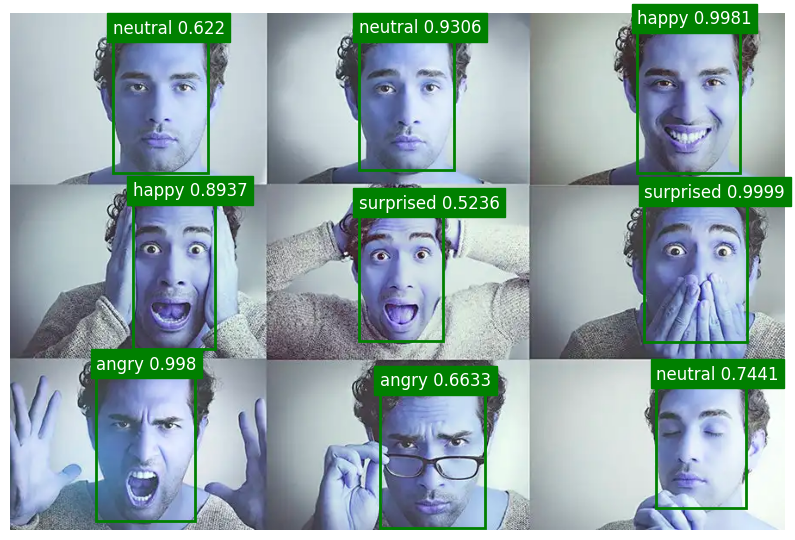

In [17]:
import torch.nn.functional as F

# Convert the image to an array for plotting
image_np = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# Plotting the results
plt.figure(figsize=(10, 10))
plt.imshow(image_np)

# Loop through the detections and plot bounding boxes
for i in range(len(results.xyxy)):  # Assuming results.xyxy[0] contains detections
    box = results.xyxy[i][:4]  # Get bounding box coordinates
    class_id = int(results.class_id[i])  # Get class id
    confidence = results.confidence[i]  # Get confidence score
    label = f'Class {class_id} {confidence:.2f}'

    x1, y1, x2, y2 = map(int,box)
    face = image_np[y1:y2, x1:x2]  # Crop the face
    face_resized = cv2.resize(face, (48,48))
    image_tensor = torch.tensor(face_resized, dtype=torch.float32).permute(2, 0, 1)/255.0
    image_tensor = image_tensor.unsqueeze(0).to(device)
    logits = emotion_model(image_tensor)
    probabilities = F.softmax(logits, dim=1)
    max_probabilities, classification = torch.max(probabilities, dim = 1)
    label = f'{labeltoemotion[int(classification[0])]} {int(max_probabilities * 10000)/10000}'
    # Create a rectangle around the detected object
    plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                        edgecolor='green', facecolor='none', linewidth=2))
    # classification = np.argmax(emotion_model)

    # Add label to the bounding box
    plt.text(box[0], box[1], label, fontsize=12, color='white', backgroundcolor='green')

# Display the image with detections
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()